# Day 6:  Stable Baseline And Gymnasium 

This is a simple experimentation with Stable Baselines and Gymnasium. The goal is to understand how to use Stable Baselines with Gymnasium and how to train a model using Stable Baselines.
Goals:
- [ ] Train a model using Stable Baselines
- [ ] Be able to swap between gymnasium environments
- [ ] Make a paramter sweep using wandb

Imports:

In [1]:
import MyUtils.Util.Misc as util

2024-08-31 22:46:21.916197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 22:46:21.933406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 22:46:21.933444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 22:46:21.945380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-31 22:46:22.727654: W tensorflow/compiler/tf

In [11]:
import os
import gc
import sys
import torch
import time
from omegaconf import OmegaConf
import gymnasium as gym
import stable_baselines3 as sb3
from IPython.display import Video
import matplotlib.pyplot as plt
import math
import numpy as np
import wandb


Check GPU:

In [3]:
# Throw error if no gpu available
assert torch.cuda.is_available(), "No GPU available"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Cofiguration

In [4]:
cfg = util.load_and_override_config(".", "config")

## Inspect environment

Inspect the environment to understand the observation space and action space. 

Get some images from the environment to understand the environment.

Make a random action agent to understand the environment.


In [5]:
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV26Environment-v0', 'GymV21Environment-v0', 'Adventure-v0', 'AdventureDeterministic-v0', 'AdventureNoFrameskip-v0

### Cartpole

Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Cartpole-v1-episode-0.mp4.
Moviepy - Writing video /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Cartpole-v1-episode-0.mp4



/tmp/ipykernel_1343/497776470.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  observations = torch.tensor(observations)


Moviepy - Done !
Moviepy - video ready /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Cartpole-v1-episode-0.mp4
Recording complete. Video saved in 'gym_recordings' directory.


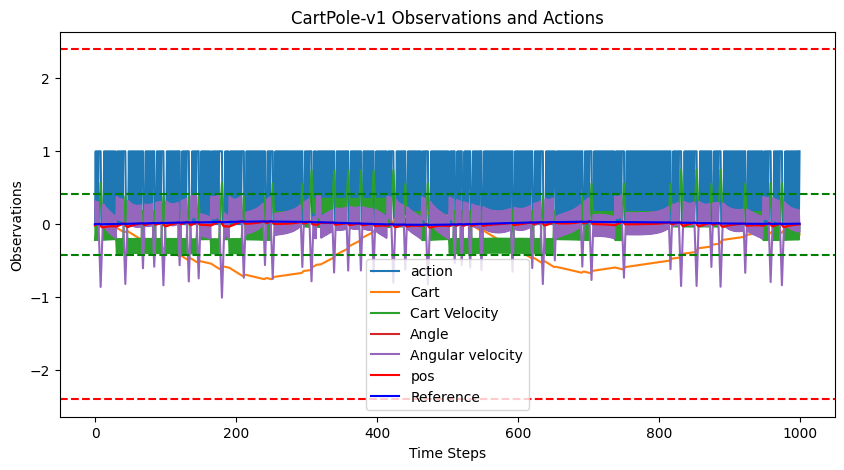

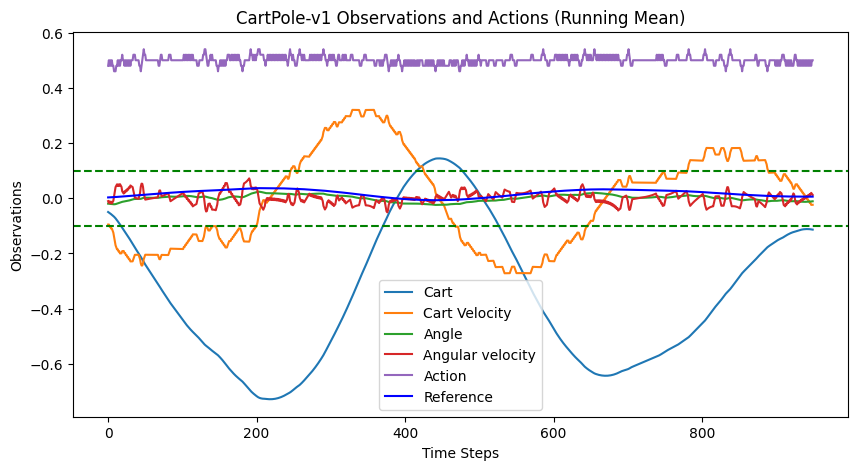

In [6]:
env = gym.make('CartPole-v1', render_mode='rgb_array',max_episode_steps=1000)
# Create a directory for storing the recorded video
video_dir = "gym_recordings"
env = gym.wrappers.RecordVideo(env, video_dir,name_prefix='Cartpole-v1')
# delete old video
video_path = os.path.join(video_dir, 'Cartpole-v1-episode-0.mp4')
if os.path.exists(video_path):
    os.remove(video_path)
# Inspect action and observation spaces
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
# Initialize the environment and start recording
#The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
#The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)
# change truncation limit to avoid long output

obs = env.reset()[0]
observations = []
actions = []
references = []
done = False
truncated = False
reference = 0
while not (done or truncated):
    action = env.action_space.sample()  # Sample a random action
    reference= max(min(obs[0]*-0.05+obs[1]*-0.005 ,0.1),-0.1)
    action = 1 if (obs[2] > reference  and obs[3] > -0.1) or not (obs[2] < reference  and obs[3] < 0.1) else 0
    obs, reward, done,truncated, info  = env.step(action)
    #print ( obs,action)
    observations.append(obs)
    actions.append(action)
    references.append(reference)
env.close()
env.env.close()
#make arrays
observations = torch.tensor(observations)
actions = torch.tensor(actions)
references = torch.tensor(references)
print(f"Recording complete. Video saved in '{video_dir}' directory.")

# plot the observations and actions
plt.figure(figsize=(10, 5))
plt.plot(actions)
plt.plot(observations)
plt.plot(observations[:,2], 'r-')
plt.plot(references, 'b-')

plt.legend(['action','Cart','Cart Velocity','Angle', 'Angular velocity','pos','Reference'])
plt.xlabel('Time Steps')
plt.ylabel('Observations')
plt.title('CartPole-v1 Observations and Actions')
# shot limits for state
plt.axhline(y=2.4, color='r', linestyle='--')
plt.axhline(y=-2.4, color='r', linestyle='--')
plt.axhline(y=0.418, color='g', linestyle='--')
plt.axhline(y=-0.418, color='g', linestyle='--')
plt.show()
# simple running mean of the observations and actions
window_size = 50
running_mean = lambda x: [sum(x[i:i+window_size])/window_size for i in range(len(x)-window_size)]
plt.figure(figsize=(10, 5))
plt.plot(running_mean(observations))
plt.plot(running_mean(actions))
plt.plot(running_mean(references), 'b-')
plt.axhline(y=0.1, color='g', linestyle='--')
plt.axhline(y=-0.1, color='g', linestyle='--')
plt.legend(['Cart','Cart Velocity','Angle', 'Angular velocity', 'Action','Reference'])
plt.xlabel('Time Steps')
plt.ylabel('Observations')  
plt.title('CartPole-v1 Observations and Actions (Running Mean)')
plt.show()

# Specify the video path
video_path = os.path.join(video_dir, 'Cartpole-v1-episode-0.mp4')

# Display the video
Video(video_path)


### Reinforcement Learning Solution 


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | 24       |
| time/              |          |
|    fps             | 881      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 28.8         |
|    ep_rew_mean          | 28.8         |
| time/                   |              |
|    fps                  | 716          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0079995245 |
|    clip_fraction        | 0.105        |
|    clip_range           | 0.2          |
|    e

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Moviepy - Building video /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Cartpole-v1-episode-0.mp4.
Moviepy - Writing video /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Cartpole-v1-episode-0.mp4



/tmp/ipykernel_1343/3305932127.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  references = torch.tensor(references)


Moviepy - Done !
Moviepy - video ready /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Cartpole-v1-episode-0.mp4
Recording complete. Video saved in 'gym_recordings' directory.


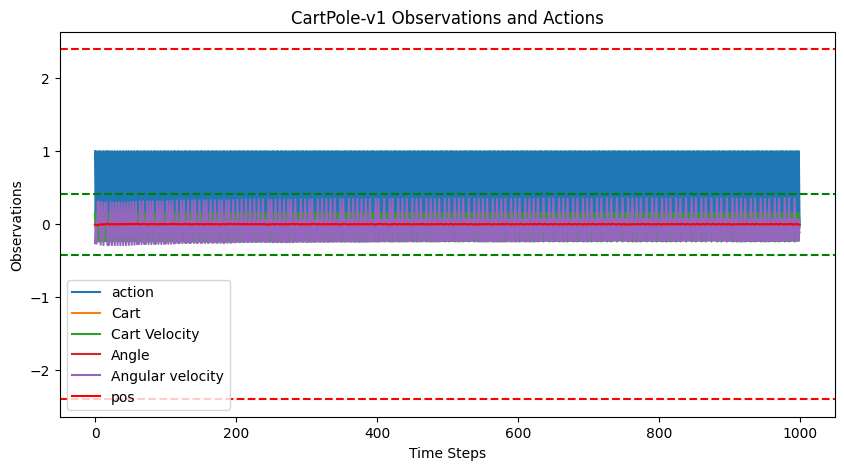

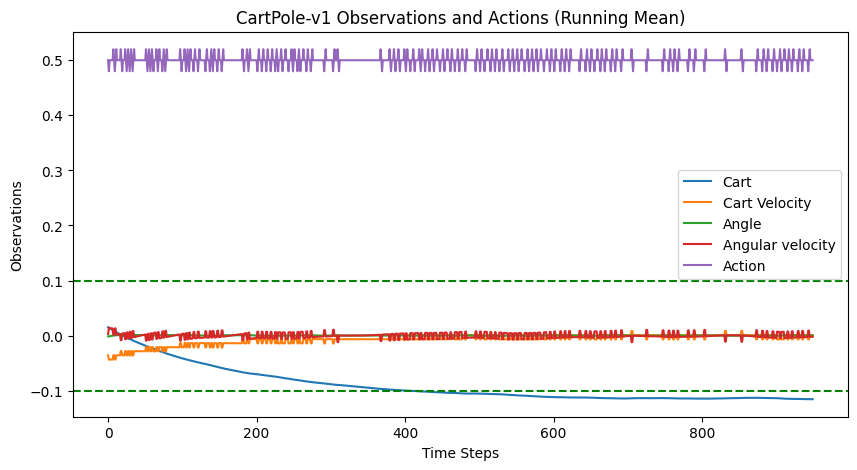

In [7]:
env = gym.make('CartPole-v1', render_mode='rgb_array',max_episode_steps=1000)
# Create a directory for storing the recorded video

# Initialize the environment and start recording
#The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.
#The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)
# change truncation limit to avoid long output
# Train a SB3 model
# Disable the video recording
model = sb3.PPO("MlpPolicy", env, verbose =1)
model.learn(total_timesteps=100000)


video_dir = "gym_recordings"
env = gym.wrappers.RecordVideo(env, video_dir,name_prefix='Cartpole-v1')
# delete old video
video_path = os.path.join(video_dir, 'Cartpole-v1-episode-0.mp4')
if os.path.exists(video_path):
    os.remove(video_path)
# Inspect action and observation spaces
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")



obs = env.reset()[0]
observations = []
actions = []
done = False
truncated = False
while not (done or truncated):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done,truncated, info  = env.step(action)
    #print ( obs,action)
    observations.append(obs)
    actions.append(action.item())
env.close()
env.env.close()
#make arrays
observations = torch.tensor(observations)
# array to tensor

actions = torch.tensor(actions)
references = torch.tensor(references)
print(f"Recording complete. Video saved in '{video_dir}' directory.")

# plot the observations and actions
plt.figure(figsize=(10, 5))
plt.plot(actions)
plt.plot(observations)
plt.plot(observations[:,2], 'r-')

plt.legend(['action','Cart','Cart Velocity','Angle', 'Angular velocity','pos'])
plt.xlabel('Time Steps')
plt.ylabel('Observations')
plt.title('CartPole-v1 Observations and Actions')
# shot limits for state
plt.axhline(y=2.4, color='r', linestyle='--')
plt.axhline(y=-2.4, color='r', linestyle='--')
plt.axhline(y=0.418, color='g', linestyle='--')
plt.axhline(y=-0.418, color='g', linestyle='--')
plt.show()
# simple running mean of the observations and actions
window_size = 50
running_mean = lambda x: [sum(x[i:i+window_size])/window_size for i in range(len(x)-window_size)]
plt.figure(figsize=(10, 5))
plt.plot(running_mean(observations))
plt.plot(running_mean(actions))
plt.axhline(y=0.1, color='g', linestyle='--')
plt.axhline(y=-0.1, color='g', linestyle='--')
plt.legend(['Cart','Cart Velocity','Angle', 'Angular velocity', 'Action'])
plt.xlabel('Time Steps')
plt.ylabel('Observations')  
plt.title('CartPole-v1 Observations and Actions (Running Mean)')
plt.show()

# Specify the video path
video_path = os.path.join(video_dir, 'Cartpole-v1-episode-0.mp4')

# Display the video
Video(video_path)

#### RL Model with wandb

In [8]:
# init wandb

# init Environment

# init model

# train model

# evaluate model

## Acrobot

## Observation Space

The observation is a `ndarray` with shape `(6,)` that provides information about the two rotational joint angles as well as their angular velocities:

| Num | Observation                   | Min                     | Max                     |
|-----|-------------------------------|-------------------------|-------------------------|
| 0   | Cosine of `theta1`            | -1                      | 1                       |
| 1   | Sine of `theta1`              | -1                      | 1                       |
| 2   | Cosine of `theta2`            | -1                      | 1                       |
| 3   | Sine of `theta2`              | -1                      | 1                       |
| 4   | Angular velocity of `theta1`  | ~-12.567 (-4 * pi)      | ~12.567 (4 * pi)        |
| 5   | Angular velocity of `theta2`  | ~-28.274 (-9 * pi)      | ~28.274 (9 * pi)        |



Action space: Discrete(3)
Observation space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Moviepy - Building video /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Acrobot-v1-episode-0.mp4.
Moviepy - Writing video /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Acrobot-v1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /workspaces/AModelADay/Days/Day_006_StableBaseline_gymnasium/gym_recordings/Acrobot-v1-episode-0.mp4
Recording complete. Video saved in 'gym_recordings' directory.


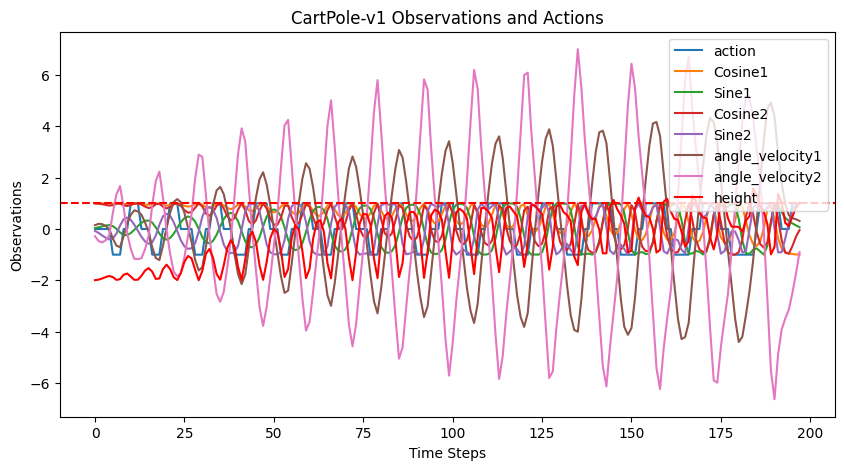

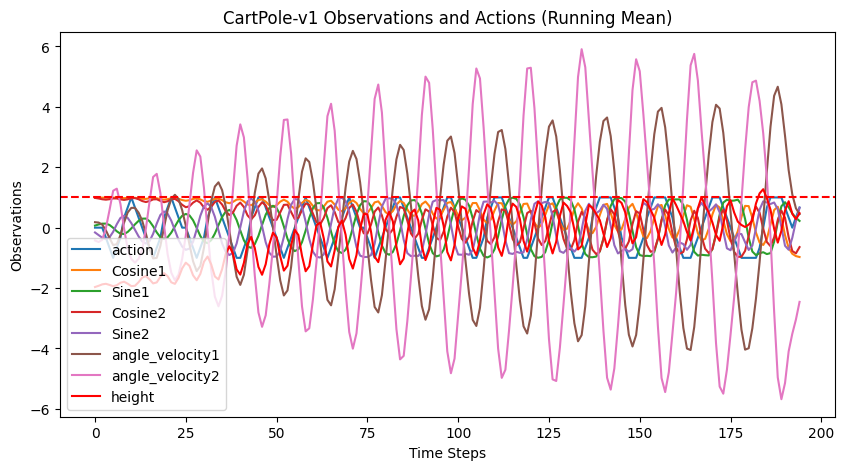

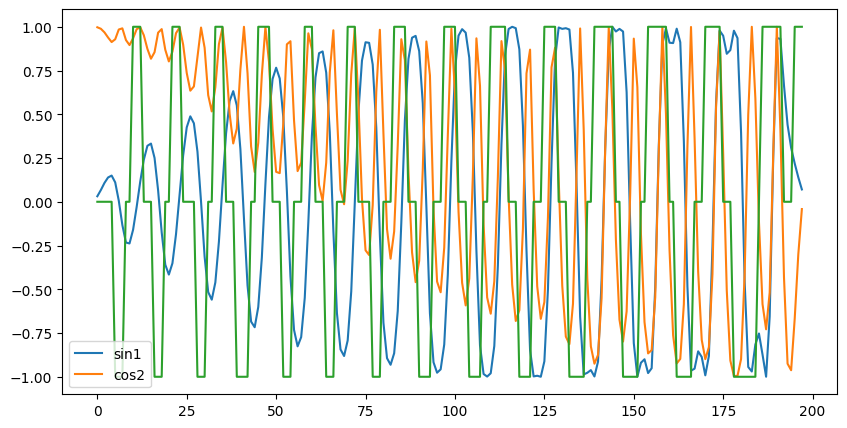

In [9]:
env_name  = 'Acrobot-v1'
env = gym.make(env_name, render_mode='rgb_array',max_episode_steps=1000)
# Create a directory for storing the recorded video
video_dir = "gym_recordings"
env = gym.wrappers.RecordVideo(env, video_dir,name_prefix=env_name)
# delete old video
video_path = os.path.join(video_dir, env_name+'-episode-0.mp4')
if os.path.exists(video_path):
    os.remove(video_path)
# Inspect action and observation spaces
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
# Initialize the environment and start recording
# 
#Termination: The free end reaches the target height, which is constructed as: -cos(theta1) - cos(theta2 + theta1) > 1.0

obs = env.reset()[0]
observations = []
actions = []
heights = []
done = False
truncated = False
def get_height(obs):
    theta1 = math.acos(obs[0])
    theta2 = math.acos(obs[2])
    return -obs[0]-math.cos(theta2+theta1)

while not (done or truncated):
    action = env.action_space.sample()  # Sample a random action
    cos1 = obs[0]
    sin1 = obs[1]
    cos2 = obs[2]
    sin2 = obs[3]
    angle_velocity1 = obs[4]
    angle_velocity2 = obs[5]

    action = 1 if (sin1<0) and cos2>0.8 else -1
    action = 1 if angle_velocity1>0 else -1
    action = action if sin2 * angle_velocity1>0 else 0
    obs, reward, done,truncated, info  = env.step(action)
    #print ( obs,action)
    observations.append(obs)
    actions.append(action)
    heights.append(get_height(obs))

env.close()
env.env.close()
#make arrays
observations = torch.tensor(observations)
actions = torch.tensor(actions)
print(f"Recording complete. Video saved in '{video_dir}' directory.")

# plot the observations and actions
plt.figure(figsize=(10, 5))
plt.plot(actions)
plt.plot(observations)
plt.plot(heights, 'r-')

plt.legend(['action','Cosine1','Sine1','Cosine2','Sine2','angle_velocity1','angle_velocity2','height'])
plt.xlabel('Time Steps')
plt.ylabel('Observations')
plt.title('CartPole-v1 Observations and Actions')
# shot limits for state
plt.axhline(y=1.0, color='r', linestyle='--')
plt.show()
# simple running mean of the observations and actions
window_size = 3
running_mean = lambda x: [sum(x[i:i+window_size])/window_size for i in range(len(x)-window_size)]
plt.figure(figsize=(10, 5))
plt.plot(running_mean(actions))
plt.plot(running_mean(observations))

plt.plot(running_mean(heights), 'r-')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.legend(['action','Cosine1','Sine1','Cosine2','Sine2','angle_velocity1','angle_velocity2','height'])

#plt.legend('action','Cosine1','Sine1','Cosine2','Sine2','angle_velocity1','angle_velocity2')
plt.xlabel('Time Steps')
plt.ylabel('Observations')  
plt.title('CartPole-v1 Observations and Actions (Running Mean)')
plt.show()
# specific signals
plt.figure(figsize=(10, 5))
#plt.plot(observations[:,0])
plt.plot(observations[:,1])
plt.plot(observations[:,2])
#plt.plot(observations[:,3])
plt.plot(actions)

plt.legend(['sin1','cos2'])
# Specify the video path
video_path = os.path.join(video_dir, env_name+'-episode-0.mp4')

# Display the video
Video(video_path)

## Prepare sweep

In [12]:
sweep_configuration_yaml = """
name: data_augmentation_sweep
program: train.py
method: grid
metric:
    goal: maximize
    name: epoch/val_acc
parameters:
    data_augmentation.layers.RandomRotation.kwargs.factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomContrast.kwargs.factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomBrightness.kwargs.factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomZoom.factor:
        values: [0, 0.1, 0.5]
    data_augmentation.layers.RandomTranslation.factor:
        values: [0, 0.1, 0.5]


  """
cfg = util.load_and_override_config(".", "config")
# Create an OmegaConf object from the YAML string
sweep_config = OmegaConf.create(sweep_configuration_yaml)

# Convert the OmegaConf object to a regular Python dictionary
wandb_sweep_config = OmegaConf.to_container(sweep_config, resolve=True)

# Ensure the dictionary is correctly formatted for wandb.sweep
wandb_sweep_config = dict(wandb_sweep_config)

# Print the converted configuration to verify
print(wandb_sweep_config)

# Initialize a Weights & Biases sweep with the configuration
sweep_id = util.get_or_create_sweep_id(cfg.project_name,wandb_sweep_config)
#wait for sweep to be created
time.sleep(5)



{'name': 'data_augmentation_sweep', 'program': 'train.py', 'method': 'grid', 'metric': {'goal': 'maximize', 'name': 'epoch/val_acc'}, 'parameters': {'data_augmentation.layers.RandomRotation.kwargs.factor': {'values': [0, 0.1, 0.5]}, 'data_augmentation.layers.RandomContrast.kwargs.factor': {'values': [0, 0.1, 0.5]}, 'data_augmentation.layers.RandomBrightness.kwargs.factor': {'values': [0, 0.1, 0.5]}, 'data_augmentation.layers.RandomZoom.factor': {'values': [0, 0.1, 0.5]}, 'data_augmentation.layers.RandomTranslation.factor': {'values': [0, 0.1, 0.5]}}}


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: kusvgy2a
Sweep URL: https://wandb.ai/frizzerdk/Day6/sweeps/kusvgy2a


## Run training Script

In [ ]:
run_scripts = False
# Define the tmux session name and the list of scripts to execute
tmux_session_name = "devenv_session"
is_sweep = True

if run_scripts:
    if is_sweep: 
        #script = ["wandb agent -p Day3 -e frizzerdk --count 20 " + sweep_id] 
        sweep_count_string = " --count " +str(cfg.sweep_count) +" " if cfg.sweep_count>0 else " "
        script = ["wandb agent -p "+cfg.project_name+" -e "+cfg.username+sweep_count_string  + sweep_id] 
        n_repeats = 1
        # Repeat the scripts n_repeats times
        scripts = script * n_repeats
    else:
        # Define the list of scripts to execute
        scripts = ["python3 train.py"] 

    # Check if the session already exists
    existing_sessions = !tmux ls 2> /dev/null
    session_exists = any(tmux_session_name in session for session in existing_sessions)

    # If the session exists, kill it
    if session_exists:
        print(f"Session '{tmux_session_name}' already exists. Killing the session.")
        !tmux kill-session -t {tmux_session_name}

    # Start a new tmux session i folder of current file
    file_path = os.path.abspath("train.py")
    print(f"Creating a new session: {tmux_session_name}")
    !tmux new-session -d -s {tmux_session_name} -n main -c {os.path.dirname(file_path)}

    # Select the first window
    first_window_name = "main"

    # Initialize the first pane with the first script
    print(f"Running script {scripts[0]} in the first pane")
    !tmux send-keys -t {tmux_session_name}:{first_window_name}.0 "{scripts[0]}" Enter

    # For subsequent scripts, create a new pane and execute the script
    for i, script in enumerate(scripts[1:], start=1):
        # sleep for 5 seconds to allow the previous script to start
        time.sleep(5)
        print(f"Creating pane {i} for script {script}")
        # Split the window to add a new pane
        !tmux split-window -t {tmux_session_name}:{first_window_name}
        # Send the command to execute the script in the new pane
        !tmux send-keys -t {tmux_session_name}:{first_window_name}.{i} "python3 {script}" Enter

    # set main-pane-width
    !tmux setw -t {tmux_session_name} main-pane-width 50%

    # Apply a layout to distribute panes evenly
    !tmux select-layout -t {tmux_session_name}:{first_window_name} main-vertical
    #!:set -g mouse on


    # Optional: Attach to the tmux session (commented for Jupyter notebook)
    #tmux attach-session -t devenv_session


## Evalutate trained models

## Load best model and evaluate